You need to install `scipy` and `ffmpeg` as additional dependencies to run the whole notebook and generate an animation.

In [109]:
import sys as _sys
import os

current_path = os.path.abspath(os.getcwd())

split = current_path.split("torchcubicspline")
if len(split)<2:
    print("Please rename the repository 'torchcubicspline'")
    raise ValueError
path_to_python_scripts = os.path.join(split[0], "torchcubicspline/")
path_to_images = os.path.join(path_to_python_scripts, 'output')

if not os.path.exists(path_to_images):
    os.makedirs(path_to_images)

_sys.path.insert(0, path_to_python_scripts)

import ffmpeg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
import shutil
import torch
from torchcubicspline import (
    natural_cubic_spline_coeffs, NaturalCubicSpline
)

blue = tuple((torch.tensor([59.0, 130.0, 219.0]) / 255.0).tolist())

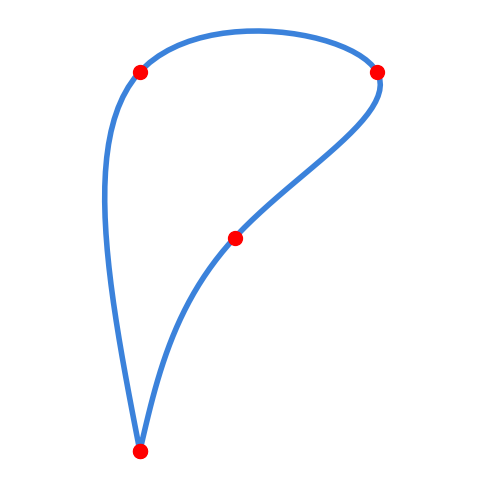

In [50]:
cps = torch.tensor([
    [0.0, -0.6], 
    [0.0, 1.0], 
    [1.0, 1.0], 
    [0.4, 0.3], 
    [0.0, 0.0],
])
cps[-1] = cps[0]
n_cp = cps.shape[0]
n_ts = 100
ts_cp = torch.linspace(0.0, 1.0, n_cp)
t = torch.linspace(0.0, 1.0, n_ts)

spline_coeffs = natural_cubic_spline_coeffs(ts_cp, cps)
spline = NaturalCubicSpline(spline_coeffs)
curve_points = spline.evaluate(t)

plt.figure(figsize=(6, 6))
plt.plot(curve_points[:, 0], curve_points[:, 1], zorder=0, c=blue, lw=4.0)
plt.scatter(cps[:, 0], cps[:, 1], s=100, c='r', zorder=1)
plt.axis('equal')
plt.axis('off')
plt.savefig(os.path.join(path_to_images, "curve_open.png"), bbox_inches='tight', pad_inches=0.0, dpi=300, transparent=True)
plt.show()

tensor([-1.1102e-16,  1.1102e-16])
tensor([-8.8818e-16,  0.0000e+00])
tensor([-7.1054e-15,  1.4211e-14])


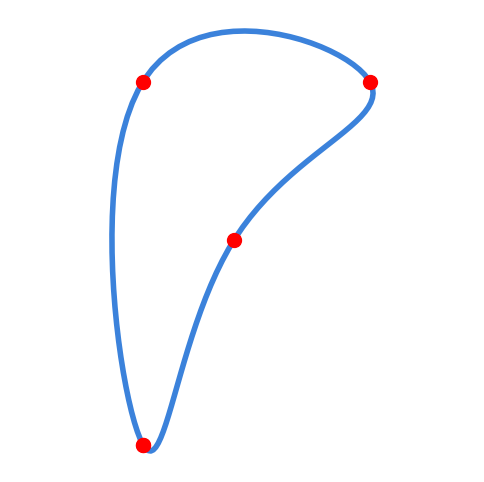

In [51]:
n_cp = cps.shape[0]
n_ts = 100
ts_cp = torch.linspace(0.0, 1.0, n_cp)
t = torch.linspace(0.0, 1.0, n_ts)

spline_coeffs_closed = natural_cubic_spline_coeffs(ts_cp, cps, close_spline=True)
spline_closed = NaturalCubicSpline(spline_coeffs_closed)
curve_points_closed = spline_closed.evaluate(t)
curve_der_closed = spline_closed.derivative(ts_cp, order=1)
curve_secder_closed = spline_closed.derivative(ts_cp, order=2)

print(curve_points_closed[-1] - curve_points_closed[0])
print(curve_der_closed[-1] - curve_der_closed[0])
print(curve_secder_closed[-1] - curve_secder_closed[0])

plt.figure(figsize=(6, 6))
plt.plot(curve_points_closed[:, 0], curve_points_closed[:, 1], zorder=0, c=blue, lw=4.0)
plt.scatter(cps[:, 0], cps[:, 1], s=100, c='r', zorder=1)
plt.axis('off')
plt.axis('equal')
plt.savefig(os.path.join(path_to_images, "curve_closed.png"), bbox_inches='tight', pad_inches=0.0, dpi=300, transparent=True)
plt.show()

# Optimize towards a circle

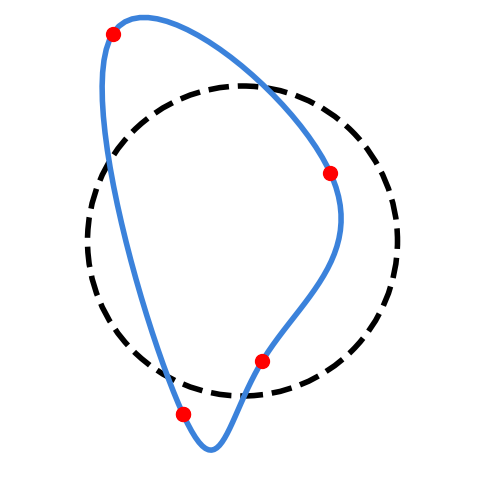

In [97]:
cps_init = torch.tensor([
    [-1.0, -1.0], 
    [1.0, -1.0], 
    [1.0, 1.0], 
    [-1.0, 1.0], 
    [0.0, 0.0],
])
torch.manual_seed(0)
cps_init += 0.4 * torch.randn(5, 2)
cps_init[-1] = cps_init[0]
n_cp = cps_init.shape[0]
n_ts = 100
ts_cp = torch.linspace(0.0, 1.0, n_cp)
t = torch.linspace(0.0, 1.0, n_ts)

spline_coeffs_closed = natural_cubic_spline_coeffs(ts_cp, cps_init, close_spline=True)
spline_closed = NaturalCubicSpline(spline_coeffs_closed)
curve_points_init = spline_closed.evaluate(t)

plt.figure(figsize=(6, 6))
plt.plot(curve_points_init[:, 0], curve_points_init[:, 1], zorder=0, c=blue, lw=4.0)
plt.scatter(cps_init[:, 0], cps_init[:, 1], s=100, c='r', zorder=1)
circle = plt.Circle((0.0, 0.0), 1.0, color='k', ls="--", fill=False, lw=4.0, zorder=-1)
plt.gca().add_artist(circle)
plt.axis('off')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig(os.path.join(path_to_images, "curve_step_000.png"), bbox_inches='tight', pad_inches=0.0, dpi=300, transparent=True)
plt.show()

In [111]:
def obj_norm_fitting(pts):
    '''
    Args:
        pts (torch.Tensor of shape (n_pts, 2)): Points to fit on the unit circle.

    Returns:
        obj (torch.Tensor of shape ()): Objective value.
    '''
    return 0.5 * torch.mean((torch.linalg.norm(pts, dim=1) - torch.tensor(1.0)) ** 2)

def obj_and_grad_params(params, n_ts):
    '''
    Args:
        params (np.ndarray of shape (n_params,)): Parameters of the optimization problem.
        n_ts (int): Number of points to sample on the current spline.
        
    Returns:
        obj (float): Objective value.
        grad_params (np.ndarray of shape (n_params,)): Gradient of the objective w.r.t. the parameters.
    '''
    params_torch = torch.tensor(params)
    params_torch.requires_grad = True
    params_reshaped = params_torch.reshape(-1, 2)
    n_cp_params = params_reshaped.shape[0]
    cps = torch.zeros(size=(n_cp_params+1, 2))
    cps[:-1] = params_reshaped
    cps[-1] = params_reshaped[0]

    ts_cp = torch.linspace(0.0, 1.0, n_cp_params+1)
    t = torch.linspace(0.0, 1.0, n_ts)

    spline_coeffs_closed = natural_cubic_spline_coeffs(ts_cp, cps, close_spline=True)
    spline_closed = NaturalCubicSpline(spline_coeffs_closed)
    curve_points = spline_closed.evaluate(t)
    
    obj = obj_norm_fitting(curve_points)
    obj.backward(torch.ones_like(obj))
    grad = params_torch.grad.numpy()
    
    return obj.item(), grad


class OptimCallback:

    def __init__(self, n_ts, path_to_images):
        self.n_ts = n_ts
        self.path_to_images = path_to_images
        self.cpt = 1

    def optim_callback(self, params):
        params_torch = torch.tensor(params)
        params_reshaped = params_torch.reshape(-1, 2)
        n_cp_params = params_reshaped.shape[0]
        cps = torch.zeros(size=(n_cp_params+1, 2))
        cps[:-1] = params_reshaped
        cps[-1] = params_reshaped[0]

        ts_cp = torch.linspace(0.0, 1.0, n_cp_params+1)
        t = torch.linspace(0.0, 1.0, self.n_ts)

        spline_coeffs_closed = natural_cubic_spline_coeffs(ts_cp, cps, close_spline=True)
        spline_closed = NaturalCubicSpline(spline_coeffs_closed)
        curve_points = spline_closed.evaluate(t)

        plt.figure(figsize=(6, 6))
        plt.plot(curve_points[:, 0], curve_points[:, 1], zorder=0, c=blue, lw=4.0)
        plt.scatter(cps[:, 0], cps[:, 1], s=100, c='r', zorder=1)
        circle = plt.Circle((0.0, 0.0), 1.0, color='k', ls="--", fill=False, lw=4.0, zorder=-1)
        plt.gca().add_artist(circle)
        plt.axis('off')
        plt.axis('equal')
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.savefig(os.path.join(self.path_to_images, "curve_step_{:03d}.png".format(self.cpt)), bbox_inches='tight', pad_inches=0.0, dpi=300, transparent=True)
        plt.close()
        self.cpt += 1


obj_and_grad_scipy = lambda x: obj_and_grad_params(x, n_ts)
optim_saver = OptimCallback(n_ts, path_to_images)
optim_callback = optim_saver.optim_callback

In [112]:
params0 = cps_init[:-1].reshape(-1,).numpy()
bnds = Bounds()

if os.path.exists(path_to_images):
    shutil.rmtree(path_to_images)
os.makedirs(path_to_images)
result = minimize(
    obj_and_grad_scipy, params0, bounds=bnds, jac=True, 
    method='BFGS', options={'disp': True, 'maxiter': 100, 'ftol': 1.0e-12, 'gtol': 1.0e-10},
    callback=optim_callback,
)

/var/folders/n_/96jdh54s7ql1w8rmkxx88xpc0000gp/T/ipykernel_99679/1614024971.py:7: OptimizeWarning: Unknown solver options: ftol
  result = minimize(


Optimization terminated successfully.
         Current function value: 0.000049
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 35


In [113]:
params_opt = torch.tensor(result.x)
params_reshaped = params_opt.reshape(-1, 2)
n_cp_params = params_reshaped.shape[0]
cps_opt = torch.zeros(size=(n_cp_params+1, 2))
cps_opt[:-1] = params_reshaped
cps_opt[-1] = params_reshaped[0]

ts_cp = torch.linspace(0.0, 1.0, n_cp_params+1)
t = torch.linspace(0.0, 1.0, n_ts)

spline_coeffs_closed = natural_cubic_spline_coeffs(ts_cp, cps_opt, close_spline=True)
spline_closed = NaturalCubicSpline(spline_coeffs_closed)
curve_points_opt = spline_closed.evaluate(t)

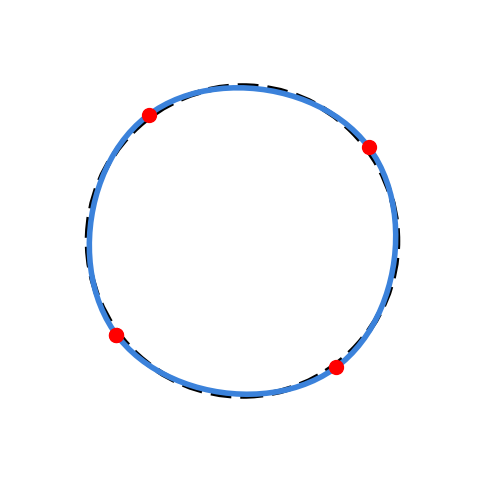

In [114]:
plt.figure(figsize=(6, 6))
plt.plot(curve_points_opt[:, 0], curve_points_opt[:, 1], zorder=0, c=blue, lw=4.0)
plt.scatter(cps_opt[:, 0], cps_opt[:, 1], s=100, c='r', zorder=1)
circle = plt.Circle((0.0, 0.0), 1.0, color='k', ls="--", fill=False, lw=4.0, zorder=-1)
plt.gca().add_artist(circle)
plt.axis('off')
plt.axis('equal')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig(os.path.join(path_to_images, "curve_final.png"), bbox_inches='tight', pad_inches=0.0, dpi=300, transparent=True)
plt.show()

In [115]:
def produce_video_from_path(
        im_pattern, save_folder, anim_fn, 
        framerate=25, transparent=False, overwrite_anim=False
    ):
    '''Concatenates images into one video
    
    Args:
        im_pattern: string representing the pattern of the images to be concatenated
        save_folder: string representing the folder where the video will be saved
        anim_fn: string representing the name of the video
        framerate: int representing the framerate of the video
        transparent: bool representing whether the images have transparency
        overwrite_anim: bool representing whether to overwrite the video if it already exists
    '''
    video_name = os.path.join(save_folder, anim_fn)
    if transparent:
        (
            ffmpeg
            .input(im_pattern, pattern_type='sequence', framerate=framerate)
            .filter('crop', w='trunc(iw/2)*2', h='trunc(ih/2)*2')
            .output(video_name, vcodec='png')
            .run(overwrite_output=overwrite_anim)
        )
    else:
        (
            ffmpeg
            .input(im_pattern, pattern_type='sequence', framerate=framerate)
            .filter('crop', w='trunc(iw/2)*2', h='trunc(ih/2)*2')
            .output(video_name, vcodec='libx264', pix_fmt='yuv420p')
            .run(overwrite_output=overwrite_anim)
        )

fn_pattern = os.path.join(path_to_images, "curve_step_%03d.png")
produce_video_from_path(
    fn_pattern, path_to_images, 
    "curve_optim.mp4", overwrite_anim=True, framerate=25
)

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 16.0.6
  configuration: --prefix=/Users/qbecker/miniforge3/envs/mfsc_env --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1719926448042/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib -